# Task 2: Build an algorithm to quantify pitch quality
---
### Prompt

The CSV “all_pitches_trackman.csv” contains fastballs and sliders thrown by LHP vs. LHH in MLB. Build a pitch grading algorithm that assesses the quality of each individual pitch (independent of its results).  

Your response should include:
* A description of your methodology, model selection, and validation.
* A summary of your results including an assessment of the success rate of your model  

![Image from SBNation](baseball.png)
<center>Image from SBNation</center>


### Data Overview
- `pitch_uid`: distinct numbering for each pitch in the data set
- `pitch_call`: event field of pitch call
- `play_result`: release speed of pitch, in MPH, when it leaves the pitcher’s hand
- `*rel_speed`: speed of pitch when it leaves pitcher's hand (mph)
- `spin_rate`: the rate the ball is spinning as it leaves the pitcher's hand in RPM
- `*spin_axis`: direction the ball is spinning (degrees tilt) 0 deg is a classic "12-6" curveball, 90 deg is a horizontal break to the inside (for lefty hitters)
- `rel_height`: the height above home plate at which the pitcher releases the ball (ft)
- `rel_side`: the distance from the center of the rubber at which the pitcher releases the ball (ft)
- `extension`: the distance from the pitching rubber at which the pitcher releases the ball (ft)
- `induced_vert_break`: distance in inches between where the pitch actually crosses the front of home plate height-wise, and where it would have crossed home plate height-wise if had it traveled in a perfectly straight line from release, where negative is moving more towards the ground
- `horz_break`: distance in inches between where the pitch actually crosses the front of home plate side-wise, and where it would have crossed home plate side-wise if had it traveled in a perfectly straight line from release, where negative is moving in to a left-handed hitter
- `*plate_loc_height`: the height above home plate at which the pitch crosses home plate (ft)
- `*plate_loc_side`: the distance from the center of the plate to the ball as it crosses the front of the plate. Negative numbers are inside to lefty hitters. (ft)
- `vert_appr_angle`: how steeply up or down the ball enters the zone, reported as the angle in degrees, as the pitch crosses the front of home plate. A negative number means it is sloping downward, while a positive number (rare) means it is sloping upward
- `horz_appr_angle`: left-right direction at which a pitched ball crosses the front of home plate, reported as an angle. A negative number means that the ball is moving from right to left from the pitcher’s perspective (away from a right-handed batter) as it enters the zone, and a positive number means that the ball is moving from left to right from the pitcher’s perspective (in on a right-handed batter) as it enters the zone

__NOTES__: 
* Terms with an asterisk are those that were not originally included in the prompt (but were in the CSV), or might be incorrectly described in the prompt. I think the description for `plate_loc_height` was actually for the `plate_loc_size`.
* I completed/edited the empty descriptions using [this](https://trackman.zendesk.com/hc/en-us/articles/115002776647-Radar-Measurement-Glossary-of-Terms).

### Table of Contents
> #### Part 0. [Imports](#imports)
> #### Part 1. [Initial thoughts](#thoughts)
> #### Part 2. [Existing methods for quantifying pitch quality](#existing)
> #### Part 3. [Data cleaning](#clean)
> #### Part 4. [Exploratory data analysis](#EDA)
> #### Part 5. [Creating a benchmark](#benchmark)
> #### Part 6. [Building a pitch grading algorithm](#alg)
> #### Part 7. [Next steps](#next)
---

<a id="imports"></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import seaborn as sns
import math
import os
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# Make folder to store images
current_directory = os.getcwd()
directory = f"{current_directory}/images_pitch"
if not os.path.exists(directory):
        os.mkdir(directory)

<a id="thoughts"></a>
## Initial thoughts

Our goal is to measure pitch quality independent of result. This means that we shouldn't consider `play_result` or `pitch_call` when assessing quality.

Ultimately, we need to figure out, __what factors determine a high quality pitch?__
* Is a pitch that hits the outside corner better than a pitch that hits the inside corner?
* Is a slider that has some vertical break better than a "pure" slider?
* Is a fastball that breaks into lefties better than a fastball that breaks down?
* What's the most important feature? Spin? Velocity? Angle? Location? Other?
* Is a pitch 1' outside the strike zone worse than a pitch down the middle?
* Can we compare FB and SL using only one metric? Or should they be split? 

There are a few things that we don't have:
* Game context (e.g. score, runners on base, outs, batter, stadium, umpire, pitch count, intended pitch location)
* Pitcher context (e.g. strengths, weaknesses, number of pitches thrown, height)
* Batter context (e.g. strengths, weaknesses, height, distance from plate, tendencies)

What does this mean?
1. Pitch quality has nothing to do with context of the game
2. We will not consider techniques that require context (e.g. Contextual Pitch Type Linear Weights)
3. Pitch quality will be based only on factors such as speed, spin, position, etc.

<a id="existing"></a>
## Existing methods for quantifying pitch quality

Most research related to this has not been published in peer reviewed journals. I found most of this information by reading articles found online. 

* Roegele's method - Divides strike zone into regions and averaged outcomes in each zone. Uses averages to benchmark quality.
* [QOP](https://qop2015seasonreview.files.wordpress.com/2016/03/february-2016-research-paper-mlb-pitch-quantification-and-the-qop-metric.pdf) - Rates pitches based on their level of difficulty for the batter to hit. Combines Greiner Index (seen below) with velocity. QOP includes late vertical break, horizontal break, and closeness to corners of strike zone. The proprietary linear model is not published, although a version of the Greiner Index is shown below.
$$ \text{Greiner Index} = -2.51*\text{rise} + 1.88*\text{break point} - 0.47*\text{knee dist} + 0.51*\text{total break} $$

* Strike Zone Plus/Minus - Includes qualities of the pitch itself and considers a catcher's ability to frame a pitch. The method cannot help quantify any pitch that's actually put into play.
* Swartz & Swartz - Measures pitch quality based on the pitch count and pitch descriptor (i.e. pitch location, speed, type, etc). Utilizes a random forest method.

<a id="clean"></a>
## Data cleaning

In [3]:
# Import csv data
df = pd.read_csv('all_pitches_trackman.csv', low_memory=False)
df.head(2)

,pitch_uid,pitch_type,pitch_call,play_result,rel_speed,spin_rate,spin_axis,rel_height,rel_side,extension,induced_vert_break,horz_break,plate_loc_height,plate_loc_side,vert_appr_angle,horz_appr_angle
0,848bce5d-2968-4ba9-a8d1-71e485821416,FB,StrikeSwinging,Undefined,92.614932,2062.363369,158.189582,6.657738,-1.934755,5.886618,17.054645,-6.835823,2.647593,0.109630,-5.817452,1.529552
1,39601156-09a5-417f-a6fe-cf9e969b0035,FB,BallCalled,Undefined,93.505779,2074.372290,145.191262,6.452201,-0.676566,5.902529,5.928455,-4.140085,0.884391,0.282608,-8.449087,0.629116


In [4]:
# Look for NaN values
df.isna().sum()

pitch_uid             52197
pitch_type            52197
pitch_call            52197
play_result           52197
rel_speed             52258
spin_rate             52834
spin_axis             52258
rel_height            52258
rel_side              52258
extension             52258
induced_vert_break    52258
horz_break            52258
plate_loc_height      52258
plate_loc_side        52258
vert_appr_angle       52258
horz_appr_angle       52258
dtype: int64

In [5]:
# Wow, that's a lot...
# From inspection, it looks like many rows are completely null/empty. Let's remove these rows.
df = df.dropna(how='all')

# Now how many do we have
df.isna().sum()

pitch_uid               0
pitch_type              0
pitch_call              0
play_result             0
rel_speed              61
spin_rate             637
spin_axis              61
rel_height             61
rel_side               61
extension              61
induced_vert_break     61
horz_break             61
plate_loc_height       61
plate_loc_side         61
vert_appr_angle        61
horz_appr_angle        61
dtype: int64

In [6]:
# Okay, let's insipect these further
df[df.isna().any(axis=1)].head()

,pitch_uid,pitch_type,pitch_call,play_result,rel_speed,spin_rate,spin_axis,rel_height,rel_side,extension,induced_vert_break,horz_break,plate_loc_height,plate_loc_side,vert_appr_angle,horz_appr_angle
67,8eac1e3d-055b-453c-98d3-b0529abc897a,SL,InPlay,Out,80.842009,NaN,255.650771,6.134134,-2.439056,5.583122,1.995819,7.941165,1.420696,0.798663,-8.897247,4.229365
184,f7fcea19-361d-11e8-874d-0cc47a42f1e3,SL,BallCalled,Undefined,83.109275,NaN,254.248930,5.351357,-2.633465,5.970955,2.520156,9.053865,2.739340,-1.523237,-6.497125,2.089882
222,0894dd46-40e0-11e8-8730-0cc47a42f1c9,SL,BallCalled,Undefined,86.911316,NaN,196.319712,6.254635,-1.852584,5.637163,9.369385,2.752454,1.426284,1.330969,-7.877228,3.678658
229,1161464b-361e-11e8-874d-0cc47a42f1e3,SL,FoulBall,Undefined,83.114620,NaN,199.267863,5.407203,-2.731411,6.204655,9.016269,3.163452,2.549120,-1.038103,-6.162513,2.149074
298,16dd39fb-3470-11e8-870a-0cc47a45ce1b,SL,BallCalled,Undefined,81.287170,NaN,310.898004,6.076918,-2.271575,4.907016,-3.122923,3.563223,3.812144,-0.782681,-6.917180,1.919680


In [7]:
# It looks like in some rows, only 'spin_rate' is null, while in other rows most everything is null
# let's investigate

# Lets remove the rows where most everything is null
idx_to_remove = df[df[['extension']].isna().any(axis=1)].index
df = df.drop(idx_to_remove)

# For now, I'm going to leave NaN spin_rate as is. 
# I'll come back to this after doing some EDA to see how best to deal with it
df.isna().sum()

pitch_uid               0
pitch_type              0
pitch_call              0
play_result             0
rel_speed               0
spin_rate             576
spin_axis               0
rel_height              0
rel_side                0
extension               0
induced_vert_break      0
horz_break              0
plate_loc_height        0
plate_loc_side          0
vert_appr_angle         0
horz_appr_angle         0
dtype: int64

In [8]:
# Let's make sure our 'pitch_uid' are all unique
print("Are all pitches unique? ", len(df) == len(df['pitch_uid'].unique()))

Are all pitches unique?  True


In [9]:
# Let's convert pitch type into an integer
df.insert(loc=2, column='pitch_type_int', value= df['pitch_type'].map({'SL':0, 'FB':1}))

<a id="EDA"></a>
## Exploratory Data Analysis
Now let's do some EDA to see what our data looks like. In particular, I'm curious at distribution of pitches in each of these categories, as well as differences between FB and SL.

In [10]:
df.describe()

,pitch_type_int,rel_speed,spin_rate,spin_axis,rel_height,rel_side,extension,induced_vert_break,horz_break,plate_loc_height,plate_loc_side,vert_appr_angle,horz_appr_angle
count,46301.000000,46301.000000,45725.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000
mean,0.684434,89.133032,2238.073296,173.310543,5.853852,-2.218697,5.944533,9.314542,-5.328525,2.251383,0.230245,-6.401361,2.112293
std,0.464746,5.033738,218.024527,59.020479,0.565184,0.822552,0.505239,7.151143,9.055900,0.886434,0.835276,1.596462,1.655482
min,0.000000,69.830884,461.149269,0.054012,2.271348,-5.333208,3.623688,-48.667125,-26.395298,-2.150201,-3.826428,-14.244603,-3.335348
25%,0.000000,86.016887,2096.729380,133.827539,5.619753,-2.735423,5.622495,3.740005,-12.515609,1.680182,-0.322116,-7.425598,0.983569
50%,1.000000,90.426716,2233.631403,154.606606,5.919967,-2.189571,5.970150,10.728950,-7.280526,2.257427,0.243548,-6.205223,2.042509
75%,1.000000,92.707419,2370.443116,203.870733,6.194532,-1.685624,6.296149,15.295612,1.889626,2.822474,0.799435,-5.256737,3.178489
max,1.000000,103.288490,3726.136503,359.883393,8.513335,1.031696,7.744261,64.625719,51.117875,7.512057,4.545302,4.243111,9.981524


C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


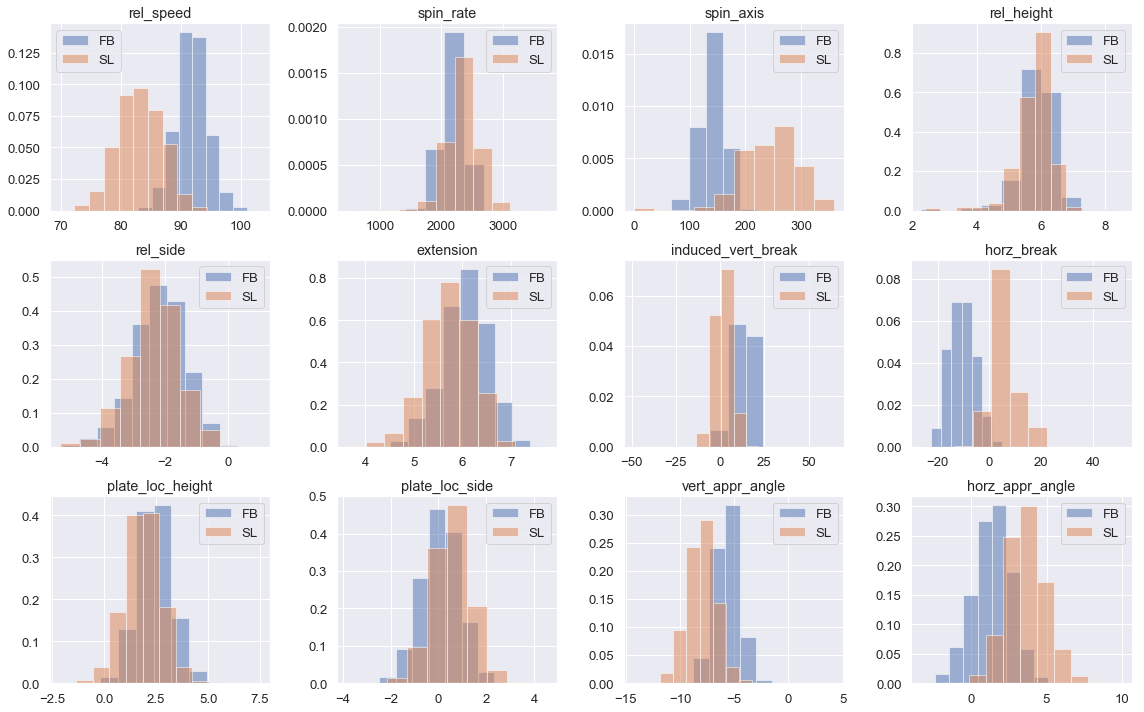

In [11]:
# Split df to help with graphs
df_FB = df[df['pitch_type'] == 'FB']
df_SL = df[df['pitch_type'] == 'SL']

# Let's plot distributions
col2 = ['rel_speed', 'spin_rate','spin_axis', 'rel_height', 'rel_side', 'extension',
       'induced_vert_break', 'horz_break', 'plate_loc_height', 'plate_loc_side', 'vert_appr_angle', 'horz_appr_angle']

plt.figure(figsize=(16,10))
for num, col in enumerate(col2):
    plt.subplot(3,4,num + 1)
    plt.hist(df_FB[col], alpha=0.5, bins=10, label='FB', density=True);
    plt.hist(df_SL[col], alpha=0.5, bins=10, label='SL', density=True);
    plt.title(f'{col}')
    plt.legend();
plt.tight_layout()
plt.savefig('.\images_pitch\distributions.png')

__Findings:__
* Gaussian distribution for all pitch features
* Twice as many FB than SL (can't explicitly see in this plot)
* FB are faster than SL
* `spin_axis`, `rel_speed`, `horz_break`, `vert_appr_angle` and `horz_appr_angle` are very different between FB and SL
* `spin_rate`, `rel_height`, `rel_side`, `plate_loc_` are generally similar

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


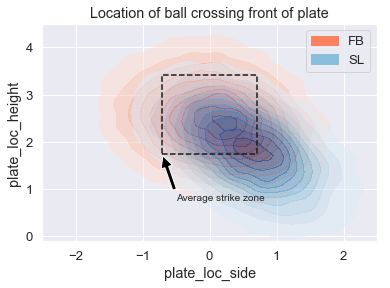

In [12]:
# Location of ball as it crosses plate

sns.kdeplot(df_FB["plate_loc_side"], df_FB["plate_loc_height"], 
            alpha=0.5, cmap="Reds", label='FB', shade=True, shade_lowest=False)
sns.kdeplot(df_SL["plate_loc_side"], df_SL["plate_loc_height"], 
            alpha=0.5, cmap="Blues", label='SL', shade=True, shade_lowest=False)
ax = plt.gca()
ax.add_patch(Rectangle((-8.5/12, 21/12), 17/12, 20/12, 
                       edgecolor='k', linewidth=1.5, linestyle='--', fill=None))
plt.xlim([-2.5,2.5])
plt.ylim([-0.1,4.5])
plt.annotate('Average strike zone', xy=(-8.5/12, 21/12), xytext=(-0.5, 0.75),
             arrowprops=dict(facecolor='black', shrink=0.05));

r = sns.color_palette("Reds")[2]
b = sns.color_palette("Blues")[2]
red_patch = mpatches.Patch(color=r, label='FB')
blue_patch = mpatches.Patch(color=b, label='SL')
plt.legend(handles=[red_patch,blue_patch])

plt.title('Location of ball crossing front of plate')
plt.savefig('.\images_pitch\pitch-location.png')
plt.show()

__Findings:__ Sliders are more often thrown outside and down, while fastballs are thrown anywhere around the plate. The average slider is hitting the outside bottom corner, while the average fastball in closer to the middle.

The average MLB strike zone was found [here.](https://www.baseballprospectus.com/news/article/14098/spinning-yarn-the-real-strike-zone-part-2/)

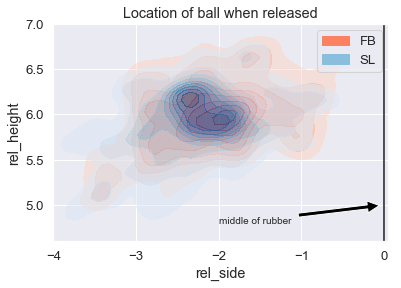

In [13]:
# Location of ball when released by pitcher

sns.kdeplot(df_FB["rel_side"], df_FB["rel_height"], 
            alpha=0.5, cmap="Reds", label='FB', shade=True, shade_lowest=False)
sns.kdeplot(df_SL["rel_side"], df_SL["rel_height"], 
            alpha=0.5, cmap="Blues", label='SL', shade=True, shade_lowest=False)
plt.axvline(linewidth=1.5, color='k')
plt.annotate('middle of rubber', xy=(0, 5), xytext=(-2, 4.8),
             arrowprops=dict(facecolor='black', shrink=0.05));
plt.xlim([-4, 0.05])
plt.ylim([4.6,7])
plt.legend(handles=[red_patch,blue_patch])
plt.title('Location of ball when released')
plt.savefig('.\images_pitch\pitch-release.png')
plt.show()

__Findings:__ There isn't a big difference between FB and SL release location. The release of fastballs is slightly higher, but only by a few inches.

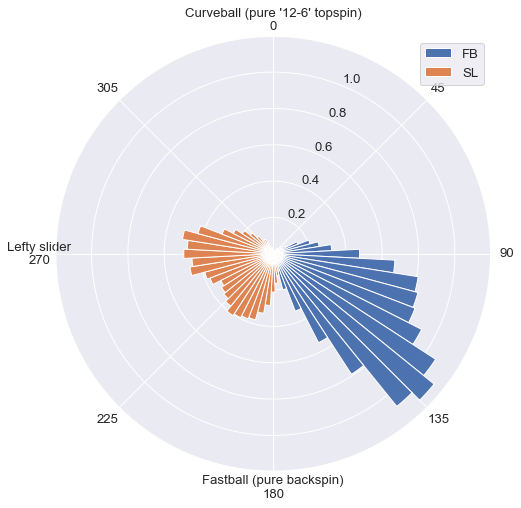

In [14]:
# Spin axis

# convert deg to rad
rad_FB = df_FB['spin_axis'].apply(math.radians)
rad_SL = df_SL['spin_axis'].apply(math.radians)

N = 60  # number of bins
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# histogram
radiiFB, tickFB = np.histogram(rad_FB, bins = N, density=True)
radiiSL, tickSL = np.histogram(rad_SL, bins = N, density=True)

# bin width
width = (2*np.pi) / N

# make a polar plot
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
barsFB = ax.bar(theta, radiiFB, width=width)
barsSL = ax.bar(theta, radiiSL, width=width)

# set the lable go clockwise and start from the top
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# labels
ticks = ["Curveball (pure '12-6' topspin)\n0", '45', '90', '135', 
         'Fastball (pure backspin)\n180', '225', 'Lefty slider\n270', '305']
ax.set_xticklabels(ticks)
plt.legend(['FB', 'SL'])
plt.savefig('.\images_pitch\spin-axis.png')
plt.show()

__Findings:__ In this figure, the length of the bars represent the density of pitches that are within a given bin. Spin angle is massively different per pitch type, though both are exactly what I'd expect. Sliders have a more lateral spin, while fastballs have more vertical spin. 

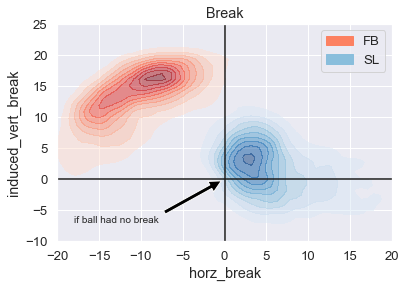

In [15]:
# Break

ax = sns.kdeplot(df_FB["horz_break"], df_FB["induced_vert_break"], 
            alpha=0.5, cmap="Reds", label='FB', shade=True, shade_lowest=False)
ax = sns.kdeplot(df_SL["horz_break"], df_SL["induced_vert_break"], 
            alpha=0.5, cmap="Blues", label='SL', shade=True, shade_lowest=False)
plt.axhline(linewidth=1.5, color='k')
plt.axvline(linewidth=1.5, color='k')
plt.annotate('if ball had no break', xy=(0, 0), xytext=(-18, -7),
             arrowprops=dict(facecolor='black', shrink=0.05));
plt.xlim([-20,20])
plt.ylim([-10, 25])
plt.legend(handles=[red_patch,blue_patch])
plt.title('Break')
plt.savefig('.\images_pitch\pitch-break.png')
plt.show()

__Findings:__ Most FB broke inside to lefties and most SL broke outside and down to lefties. These directions are expected. Intrestingly, fastballs had a greater magnitude of break than sliders (which I think has to do with the exact metric). While both appear to have positive break, this doesn't mean that they actually broke upwards. Instead, it means that they didn't break down as much as they would if gravity were the only force at play.

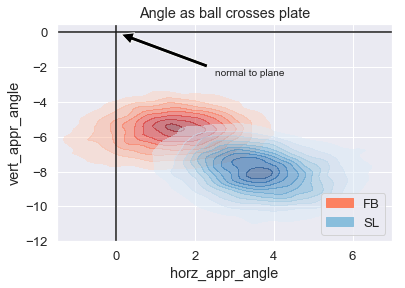

In [16]:
# Angle of ball as it crosses the plate

ax = sns.kdeplot(df_FB["horz_appr_angle"], df_FB["vert_appr_angle"], 
            alpha=0.5, cmap="Reds", label='FB', shade=True, shade_lowest=False)
ax = sns.kdeplot(df_SL["horz_appr_angle"], df_SL["vert_appr_angle"], 
            alpha=0.5, cmap="Blues", label='SL', shade=True, shade_lowest=False)
plt.axvline(linewidth=1.5, color='k')
plt.axhline(linewidth=1.5, color='k')
plt.annotate('normal to plane', xy=(0, 0), xytext=(2.5, -2.5),
             arrowprops=dict(facecolor='black', shrink=0.05));
plt.xlim([-1.5, 7])
plt.ylim([-12, 0.5])
plt.legend(handles=[red_patch,blue_patch])
plt.title('Angle as ball crosses plate')
plt.savefig('.\images_pitch\pitch-angle.png')
plt.show()

__Findings:__ Okay, I know this isn't the best visualization but let's try to use it to gain some basic intuition. Point [0,0] means there is no angle, so the ball directly normal to the plane. Negative values in the y-direction mean that the ball is angled down towards the ground. Positive values in the x-direction mean that the ball is angled such that it's moving away from lefities.

What we are seeing is that both FB and SL are hitting the plane at an angle that's down and away from lefties. Sliders however, have are cutting the plane at a larger angle, both vertically and horizontally. This is expected.

<a id="benchmark"></a>
## Creating a benchmark
Now that we've got a better feel for the data, let's start the process of building a modle. Since "pitch quality" is independent of result, let's make some assumptions about defines a high-quality pitch.

#### Worst possible outcomes
First let's start with qualities of a low-quality pitch. By setting a baseline, we can start to think about what makes a pitch great. Then we use this as a benchmark to compare other pitches to.

| Attribute 	| Indicator 	| Desc 	| Quantity 	| Units 	|
|:-------:	|:---------:	|:----:	|:--------:	|:-----:	|
|Velocity  	| `rel_speed` 	|Slow  	| 0 	| mph 	|
|Location  	| `plate_loc_side` `plate_loc_height` 	|Far from edge of strike zone  | [inf, inf]  	| [ft, ft] 	|
|Break  	| `induced_vert_break` `horz_break` 	|No break  	|[0,0]  	| [in, in]  	|
|Angle  	| `horz_appr_angle` `vert_appr_angle`  	|Flat plane  	| [0,0]  	| [deg, deg]  	|
|Extension 	| `extension` 	| No extension 	| 0 	| ft 	|
|Spin  	  	| `spin_rate` `spin_axis` 	| No spin? 	| [0,0] 	| [rpm, deg] |
|Release   	| `rel_side` `rel_height` 	| Straight on? 	| [0,0]  	| [ft, ft]  	|

Okay, I'm going to simplify things. Let's ignore spin and release point because these attributes are somewhat captured in others. For example, `spin_rate` and `spin_axis` ultimately affect `rel_speed`, `_break` and `_appr_angle`. `rel_side` and `rel_height` are captured in `_appr_angle` and `plate_loc_`. I'll note that `spin_` can affect how the ball comes off the bat and `rel_` can affect the overall trajectory of the ball and distance/time from the pitcher's hand to the plate. For simplicity, I'm going to look at the other factors.

Know that we know what a low-quality pitch is, what defines a high-quality pitch?
* Velocity - Fast
* Location - On one of the four corners of the strike zone. I'll assume each corner is equally "good".
* Break - Lot's of it, measured as deviation from 0
    * SL: horizontal break is most important, but vertical break is good too
    * FB: break is not as important, but still good
* Angle - Large angle, measured as deviation from 0
    * SL: horizontal angle is most important, but vertical angle is good too
    * FB: vertical angle might be more important
* Extension - Long extension
    * longer extensions result in a faster pitch as it crosses the plate, and quicker time from the pitcher's hand to the plate

Pretty much, we want to maximize each of these attributes (except for location, where we want to minimize distance from corner).

#### Best outcomes in dataset

Now, let's see the "best" value in the dataset for individual attribute by `pitch_type`. We can use `df.describe()` to get everything except location. For location, we need to see which pitch is closest to the edge of the strike zone. Although the height of the strike zone varies per hitter, we will assume that it's fixed at 17" wide and between 21-41" from the ground, as described [here.](https://www.baseballprospectus.com/news/article/14098/spinning-yarn-the-real-strike-zone-part-2/)

In [17]:
# Edges of strike zone
x_sz = np.array([-8.5, 8.5]) / 12
y_sz = np.array([21, 41]) / 12

# FB
print("Minimum FB distance to strike zone width: ", 
      min([np.min(np.abs(i - x_sz)) for i in df_FB['plate_loc_side']]), "ft")
print("Minimum FB distance to strike zone height: ", 
      min([np.min(np.abs(i - y_sz)) for i in df_FB['plate_loc_height']]), "ft\n")
# SL
print("Minimum SL distance to strike zone width: ", 
      min([np.min(np.abs(i - x_sz)) for i in df_SL['plate_loc_side']]), "ft")
print("Minimum SL distance to strike zone height: ", 
      min([np.min(np.abs(i - y_sz)) for i in df_SL['plate_loc_height']]), "ft")

Minimum FB distance to strike zone width:  1.0245333333380735e-05 ft
Minimum FB distance to strike zone height:  1.4809000000060024e-05 ft

Minimum SL distance to strike zone width:  9.023133333330158e-05 ft
Minimum SL distance to strike zone height:  1.693099999999781e-05 ft


<h4 align="center">Best fastball stats</h4> 

| Attribute 	| Indicator 	|  Quantity 	| Units 	|
|:-------:	|:---------:	|:--------:	|:-----:	|
|Velocity  	| `rel_speed` 	| 103.3 	| mph 	|
|Location  	| `plate_loc_side` `plate_loc_height` 	| [0, 0]  	| [ft, ft] 	|
|Break  	| `horz_break` `induced_vert_break` 	| [-26.4, 64.6]  	| [in, in]  	|
|Angle  	| `horz_appr_angle` `vert_appr_angle`  	| [3.7, -10.2]  	| [deg, deg]  	|
|Extension 	| `extension` 	| 7.7 	| ft 	|

<h4 align="center">Best slider stats</h4> 

| Attribute     | Indicator     |  Quantity     | Units     |
|:-------:  |:---------:    |:--------: |:-----:    |
|Velocity   | `rel_speed`   | 94.4  | mph   |
|Location   | `plate_loc_side` `plate_loc_height`   | [0, 0]    | [ft, ft]  |
|Break      | `horz_break` `induced_vert_break`     | [51.1, -48.7]     | [in, in]      |
|Angle      | `horz_appr_angle` `vert_appr_angle`   | [10.0, -14.2]     | [deg, deg]    |
|Extension  | `extension`   | 7.5   | ft    |

To be clear, the tables above don't represent values from a single pitch. Instead, these are the best outcomes for each individual indicator. It might have come from one pitch, or might have been from 7 different pitches.

__Findings:__ We can see that the best fastballs are faster, have more vertical break and have greater extension. The best sliders have more horizontal break than fastballs. Both pitches have perfect accuracy.

<a id="alg"></a>
## Building a pitch grading algorithm
Let's review what we've done so far. First, we cleaned the data to remove irrelevant info and to deal with null values. Then we did EDA and explored the differences between FB and SL, as well as the distributions within each pitch type. Next, we defined a baseline and looked at pitches that had the best outcomes for each attribute.

#### Preprocessing
First we will preprocess the raw data to get it into a form that we will use for grading pitch quality.
1. Convert break and angle stats to positive value since direction is not relevent for our formulation.
2. Location will computed as the _negative_ distance from the strike zone edge for both x and y components.
3. Scale features using the following formula $ z = \dfrac{x - \mu}{\sigma} $, where $\mu$ is the population mean and $\sigma$ is the standard deviation.


In [18]:
# Create feature matrix
X = df.drop(['spin_rate', 'spin_axis', 'rel_height', 'rel_side'], axis=1).copy()

# Get distance from strikezone edge
X['plate_loc_side'] = -1 * np.array([np.min(np.abs(i - x_sz)) for i in X['plate_loc_side']])
X['plate_loc_height'] = -1* np.array([np.min(np.abs(i - y_sz)) for i in X['plate_loc_height']])

# Get absolute value for break and angle 
X[['horz_break', 
   'induced_vert_break', 
   'horz_appr_angle', 
   'vert_appr_angle']] = X[['horz_break', 'induced_vert_break', 
                            'horz_appr_angle', 'vert_appr_angle']].abs()

# Scale results
scaler = StandardScaler()
col = ['rel_speed', 'horz_break', 'induced_vert_break', 
       'horz_appr_angle', 'vert_appr_angle', 'extension',
       'plate_loc_side', 'plate_loc_height']
X = scaler.fit_transform(X.loc[:, col])
X = pd.DataFrame(X, columns=col)

#### Calculating pitch quality
Let's assume that all indicators discussed when creating the benchmark are equally important (see `score`), except for 2 caveats (which are included in `score_adj`).
Caveat 1: For fastballs, `rel_velocity` is the most important feature and will be scaled by 25%.
Caveat 2: For sliders, `horz_appr_angle` is the most important feature and will be scaled by 25%.

Therefore, `score_adj` will be calculated using the the following formula. 

`score_adj` = `extension` + `plate_loc_side` + `plate_loc_height` + `horz_break` + `induced_vert_break` + 

`rel_velocity` * (1 + 0.25 * `pitch_type_int`) + 

`horz_appr_angle` * (1 + 0.25 * (1 - `pitch_type_int`))

In [19]:
# Calculate scores
X.insert(0, 'score', X.sum(axis=1))
X.insert(1,'pitch_type_int', df['pitch_type_int'])
X.insert(1, 'score_adj', 
         X['score'] + 0.25 * X['rel_speed'] * X['pitch_type_int'] + 
         0.25 * X['horz_appr_angle'] * (1 - X['pitch_type_int']))
X.insert(0,'pitch_uid', df['pitch_uid'])

X.head()

,pitch_uid,score,score_adj,pitch_type_int,rel_speed,horz_break,induced_vert_break,horz_appr_angle,vert_appr_angle,extension,plate_loc_side,plate_loc_height
0,848bce5d-2968-4ba9-a8d1-71e485821416,-0.957694,-0.784764,1.0,0.691720,-0.427263,1.167436,-0.487435,-0.366039,-0.114630,-0.580904,-0.840577
1,39601156-09a5-417f-a6fe-cf9e969b0035,-1.824311,-1.607136,1.0,0.868697,-0.938549,-0.710995,-1.100257,1.283155,-0.083138,-0.023117,-1.120107
2,55fefc05-6955-4674-988e-17f31f28c5a4,1.636531,1.850187,1.0,0.854624,0.211118,1.064946,-0.269327,0.323788,0.388354,0.240780,-1.177754
3,743ba583-f1ce-4cc4-a103-34f6a2ee22d3,-1.334572,-0.893269,0.0,-2.065364,1.294398,-1.239724,1.765214,1.164062,-1.288909,-0.494705,-0.469544
4,bd6be3ed-c225-4eb2-8526-f8d9ad2cc85b,-1.949751,-1.836197,0.0,-2.126256,0.631616,-0.987380,0.454216,0.677267,-0.421428,-0.593029,0.415243


In [20]:
X.describe().round(4)

,score,score_adj,pitch_type_int,rel_speed,horz_break,induced_vert_break,horz_appr_angle,vert_appr_angle,extension,plate_loc_side,plate_loc_height
count,46301.0000,46240.0000,46240.0000,46301.0000,46301.0000,46301.0000,46301.0000,46301.0000,46301.0000,46301.0000,46301.0000
mean,-0.0000,0.0051,0.6843,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
std,2.2466,2.3273,0.4648,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-16.7941,-17.1160,0.0000,-3.8346,-1.7238,-1.7118,-1.5284,-3.4221,-4.5936,-11.0231,-10.4723
25%,-1.3641,-1.4166,0.0000,-0.6191,-0.8233,-0.9283,-0.7927,-0.7174,-0.6374,-0.5210,-0.5653
50%,0.1660,0.1844,1.0000,0.2570,-0.0526,0.1043,-0.1313,-0.1230,0.0507,0.1239,0.0984
75%,1.5452,1.6164,1.0000,0.7101,0.7834,0.8706,0.6350,0.6418,0.6959,0.7422,0.7447
max,12.7757,12.6774,1.0000,2.8121,7.9715,9.1988,5.2648,4.9151,3.5622,1.3496,1.3863


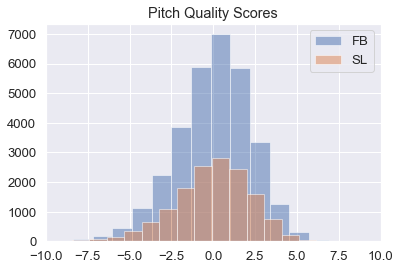

In [21]:
plt.hist(X[X['pitch_type_int'] == 1]['score'], alpha=0.5, bins=25, label='FB')
plt.hist(X[X['pitch_type_int'] == 0]['score'], alpha=0.5, bins=25, label='SL')
plt.title('Pitch Quality Scores')
plt.xlim([-10,10])
plt.legend()
plt.savefig('.\images_pitch\pitch-scores.png')
plt.show()

#### Interpretable score
Our score is a little hard to interpret. Although it's clear that negative scores are below the mean and positive scores are better than the mean, how much better is a pitch rated 3 than a pitch rated 2.5?

One way to grade the scores is to look at its percentile in the distribution. For example, one could say that the quality of a given pitch is in the 80th percentile. This is my preference.

I suppose we could also scale our scores to something a bit more digestable, like 0 to 1, with 1 being the top ranked pitch. Let's see what this would look like.

count    46240.000000
mean         0.574662
std          0.078113
min          0.000000
25%          0.526942
50%          0.580679
75%          0.628744
max          1.000000
Name: score_adj_fit, dtype: float64


C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


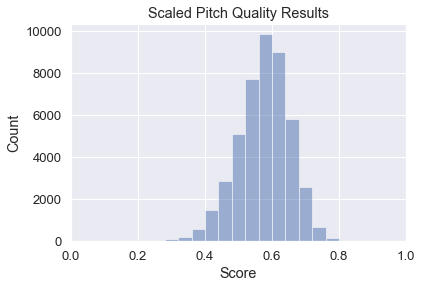

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X['score_adj_fit'] = scaler.fit_transform(X[['score_adj']])
print(X['score_adj_fit'].describe())

plt.hist(X['score_adj_fit'], alpha=0.5, bins=25)
plt.title('Scaled Pitch Quality Results')
plt.xlim([0, 1])
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

<a id="next"></a>
## Next Steps

We could also dive in to study the following questions.

1. What features define the top 5 fastballs? 
2. What features define the top 5 sliders?
3. How about the bottom 5?
4. Were our feature weights reasonable? How could they be improved?

I'll get started, but leave the rest open...

In [23]:
# Scores
top5 = X.sort_values(by='score_adj', ascending=False).head()['pitch_uid'].values
bottom5 = X.sort_values(by='score_adj', ascending=True).head()['pitch_uid'].values

# Scores by pitch type
print("5 highest ranked FB")
top5_FB = X[X['pitch_type_int'] == 1].sort_values(by='score_adj', ascending=False).head()['pitch_uid'].values
bottom5_FB = X[X['pitch_type_int'] == 1].sort_values(by='score_adj', ascending=True).head()['pitch_uid'].values
print(top5_FB)

print("\n5 highest ranked SL")
top5_SL = X[X['pitch_type_int'] == 0].sort_values(by='score_adj', ascending=False).head()['pitch_uid'].values
bottom5_SL = X[X['pitch_type_int'] == 0].sort_values(by='score_adj', ascending=True).head()['pitch_uid'].values
print(top5_SL)

# Create boolean column for convenient access of top 5 pitches in original dataframe
df['Top5_SL'] = df['pitch_uid'].isin(top5_SL)
df['Top5_FB'] = df['pitch_uid'].isin(top5_FB)

5 highest ranked FB
['bf6e0b0e-61fa-11e8-876d-0cc47a45cd67'
 '776b0ca8-534a-11e8-8773-0cc47a42f1e3'
 'ba0bcf75-2a36-4d6e-bf74-855beafcfd58'
 '4db99817-5b29-4886-b10f-c95df91f4302'
 '902b16e9-40d0-11e8-8716-0cc47a42ef89']

5 highest ranked SL
['f29cde51-8fc4-4102-a854-659d16606a1e'
 'a91a8edc-33a9-11e8-874a-0cc47a42f1e3'
 '3c6e2ef2-da29-4e58-967c-849c8f1f06ba'
 'b8d959a2-49bb-405b-b9fb-2410ac3c66bc'
 'e4404c70-ec02-40dd-a37d-8e661abf732b']


In [24]:
# Additional plots and analysis

## How correlated is pitch quality and outcome?
So we built the model with data __independent__ from the pitch's result. We could take a look at how well correlated pitch quality and outcome are. Note that the intention of our the model is for assessing pitch quality, _not_ predicting outcome!  
Let's create a single response variable `y` that maps bad outcomes (e.g. hit) to 0 and good outcomes (e.g out) to 1. We will remove all pitches that have an undefined or nan result. 

In [25]:
df_outcomes = df[['pitch_call', 'play_result']].copy()

def calc_outcome(row):
    good_outcomes = ['Out', 'FieldersChoice', 'Sacrifice', 'Error']
    bad_outcomes = ['HitByPitch', 'Single', 'Double',
                   'Triple', 'HomeRun']
    if (row['pitch_call'] in bad_outcomes) or (row['play_result'] in bad_outcomes):
        return 0
    elif (row['pitch_call'] in good_outcomes) or (row['play_result'] in good_outcomes) :
        return 1

df_outcomes['y'] = df_outcomes.apply(calc_outcome, axis=1)
df_outcomes.insert(0, 'score_adj', X['score_adj'])
df_outcomes = df_outcomes.drop(columns=['pitch_call', 'play_result']).dropna()

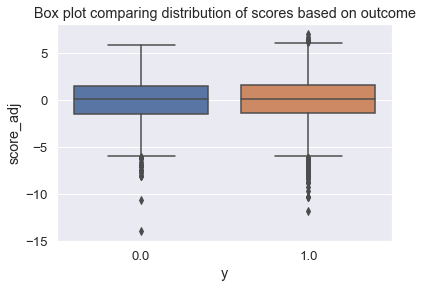

In [26]:
# plot
sns.boxplot(x='y', y='score_adj', data=df_outcomes)
plt.title('Box plot comparing distribution of scores based on outcome')
plt.show()

This graph shows that pitch quality and outcome are independent! There are many reasons for this, most notably that there are contextual factors that affect the play.